<img src="logo.png" width=15%>

### <center>Instituto Superior De Engenharia De Lisboa<br>Departamento De Engenharia de Eletrónica e Telecomunicações e de Computadores<br>Licenciatura em Engenharia Informática e Multimédia

### <center>**Aprendizagem Automática** <br>1º Trabalho Laboratorial<br>Pima Indians Diabetes Dataset
##### <center>**Turma: 51D**<br>**Alunos:**<br>Ana Carriço 50725<br>Ana Medeiros 50761<br>Gabriel Rodrigues 50787<br></br>**Docente:** Gonçalo Marques<br></br>novembro de 2024

# Índice

1. [Introdução](#intro)
2. [Enquadramento Teórico](#enquad)
3. [Modelos de Classificação](#classificacao)
4. [Pré-processamento de dados](#processamento)
5. [Comparação de desempenho de classificadores](#comparação)
6. [Observações Gerais](#observações)
7. [Conclusões](#conclusao)
8. [Referências](#refs)

<a id="intro"></a>

#### 1. Introdução

O Pima IndiansDiabetes Dataset, originalmente desenvolvido pelo Instituto Nacional de Diabetes e Doenças Digestivas e Renais dos Estados Unidos da America, contém informacões sobre 768 mulheres de uma das tribos indígenas desse país. Devido a uma alta taxa de incidência de diabetes, a populacão dos índios Pima tem estado sobre contínua vigilância pelo Instituto desde 1965, cada residente tendo sido submetido a um exame padronizado cada dois anos. Nos dados disponibilizados, 500 mulheres não têm diabetes e 268 sim. A informacão recolhida consiste nas seguintes 8 características:

<img src="caracteristicas.png" width=40% style="display: block; margin: auto;">

Neste projeto tem como objetivo determinar se os pacientes têm diabetes, baseado nos indicadores disponibilizados pelo Instituto Nacional de Diabetes e Doenças Digestivas e Renais, sendo então necessário treinar e avaliar três ou mais classificadores binários e fazer um estudo comparativos do desempenho dos modelos escolhidos.

<a id="enquad"></a>

#### 2. Enquadramento Teórico

A classificação de classes é um processo de **categorização** em que objectos, ideias, seres, etc, são agrupados por classe.<br>
Em aprendizagem automática, a classifição pode ser um processo **supervisionado**, ou seja, são associados a uma nova observação uma classe de um conjunto pré-definido de classes, usando para tal um conjunto de treino com exemplos em que se conhece a classe.<br>
Para poder usar algoritmos de classificação, os dados (objectos, ideias, seres, etc...) tem que ser representados por um conjunto finito de características. Cada corresponde a uma propriedade mensuravel dos dados. Enquato cada objecto é representado por um vector, cuja características está em cada dimensão.

A construção do modelo é baseada num conjunto de dados para as quais se conhece a classe, e é composta pelas seguinte etapas:
1. Escolher/projectar o modelo de classificação
2. Treinar o modelo.
3. Avaliar o modelo.

O processo de classificação pode ser traduzido na **divisão do espaço** de características num conjunto de c **regioes de decisão**, ou seja, definir um conjunto de c funções discriminantes.

<img src="classificadores.png" width=50% style="display: block; margin: auto;">

A **avaliação do desempenho de um classificador** é constituida pela **probabilidade total de errar (ou acertar)** independentemente das classes,
da probabilidade de errar e a distribuição dos erros em cada classe. A representação da distribuição dos erros por classe é feita através de uma **matriz de confusão**, que permite visualizar o desempenho do classificador.<br>
Normalmente, os coeficientes de uma matriz de confusão são estimados através de contagens dos resultados de classificação de dados previamente classificados (teste).<br></br>

E importante analisar o caso particular da **classificação binária**, pois esta surge em diversos domínios da aplicação.<br>
Neste caso, é habitual referir as duas classes como **positivos** e **negativos**, onde os positivos referem-se a existência ou detenção.<br>
As métricas de desempenho são baseada nos valores matriz de confusão não-normalizada. Estas são oito:<br>
* True Positives rate
* False Negatives rate
* True Negatives rate
* False Positives rate
* Positive Predicted Value
* False Dicovery Rate
* Negative Predicted Value
* False Omission Rate

In [37]:
import numpy as np
from numpy import random as rnd
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve

<a id="classificacao"></a>


#### 3. Desenvolvimento

In [ ]:
def calculate_balanced_accuracy (TP,TN,FN,FP):
    recall = TP/(FN+TP) if (FN+TP) > 0 else 0
    specificity = TN/(TN+FP) if (TP+FN) > 0 else 0

    balanced_accuracy = (recall + specificity) / 2
    return round(balanced_accuracy, 3)

'''O Critério de valiação foi a exatidão balanceada. Desta forma, tenta-se maximizar um classificador de modo a que esta seja o mais proóximo de 1 possível
    O uso conjunto de specificity e recall faz com que os Falsos negativos sejam minimizados, sem comprometer a exatidão
'''


def find_optimal_threshold(y_true, p):
    '''Variáveis temporárias para guardar os melhores valores'''

    best_threshold = 0
    best_balanced_accuracy  = 0
    best_conf = []
    best_decision_point = ()
    best_y = []
   
    thresholds = np.arange(0.0, 1.01, 0.01)  # Thresholds de 0 a 1 em passos de 0.01
    for threshold in thresholds:
        # Classificar como 1 se a probabilidade prevista for >= threshold
        y_pred = (p >= threshold)
        
        # Calcular a matriz de confusão
        conf = confusion_matrix(y_true, y_pred)
        TN, FP, FN, TP = conf.ravel()
        # Calcular o F-score com o threshold atual
        balanced_accuracy  = calculate_balanced_accuracy (TP,TN,FN,FP)
        decision_point = (FP/(TP+FP), TN / (FN+TN)) if ((FP+TP) >0 and (FN+TN) > 0) else 0

        # Atualizar o threshold ótimo se este F-score for maior
        if  balanced_accuracy  > best_balanced_accuracy  :
            best_balanced_accuracy  = balanced_accuracy 
            best_threshold = threshold
            best_conf = conf
            best_decision_point = decision_point
            best_y = y_pred
            

    return  best_y, best_conf, best_threshold, best_balanced_accuracy , best_decision_point


Neste primeiro trabalho prático, foram utilizados três classificadores:<br>
    - **Random Forest** - cria várias árvores de decisão e combina seus resultados para melhorar a precisão. Cada árvore é construída com uma amostra diferente dos dados e com um subconjunto de variáveis. Este classificador foi requerido pelo enunciado. <br>
    - **SVC (Support Vector Classifier)** - encontra uma fronteira de decisão ótima entre as classes que maximiza a margem entre as classes.<br>
    O SVC foi um dos classificadores selecionados dado que tem um bom desempenho em dados que sejam possíveis classificar de forma binária, como o apresentado relativamente a pacientes com ou sem diabetes.<br>
    - **Regressão Logística** - calcula a probabilidade de um evento. Usa uma função logística para calcular a probabilidade de uma instância pertencer a uma classe, tornando-a ideal para problemas binários. Este classificador foi escolhido por ser um modelo simples e eficaz fornececendo probabilidades que permitem interpretar, no contexto médico, a probabilidade de um paciente poder desenvolver diabetes.

Random Forest - Exatidão média: 0.7760
Random Forest - Melhor Limiar: 0.27
Matriz de Confusão para Random Forest:



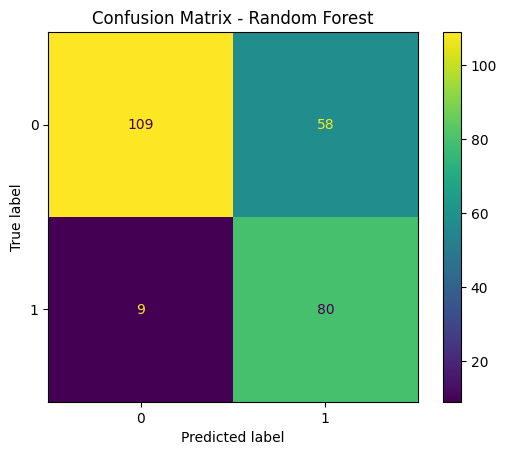

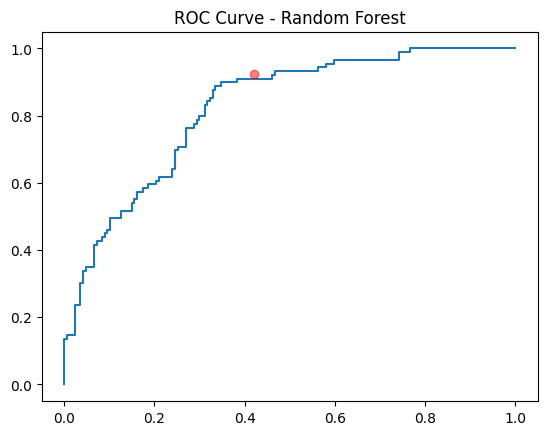

SVC - Exatidão média: 0.7710
SVC - Melhor Limiar: 0.32
Matriz de Confusão para SVC:



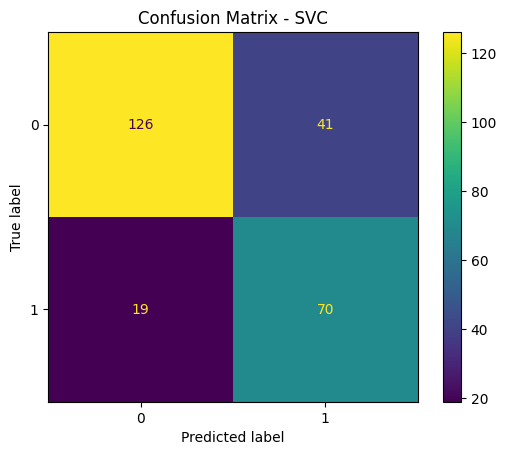

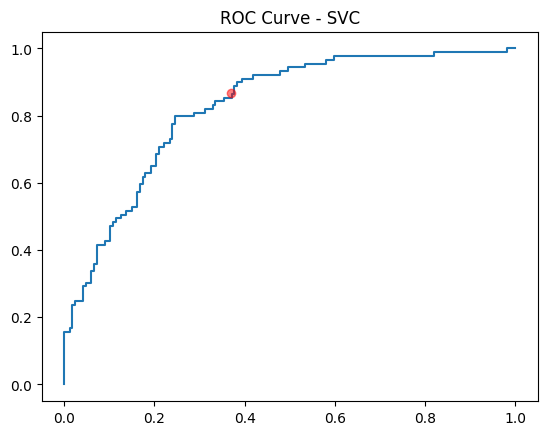

Logistic Regression - Exatidão média: 0.7630
Logistic Regression - Melhor Limiar: 0.22
Matriz de Confusão para Logistic Regression:



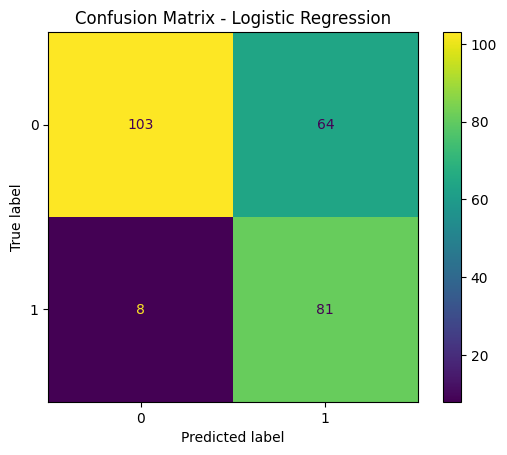

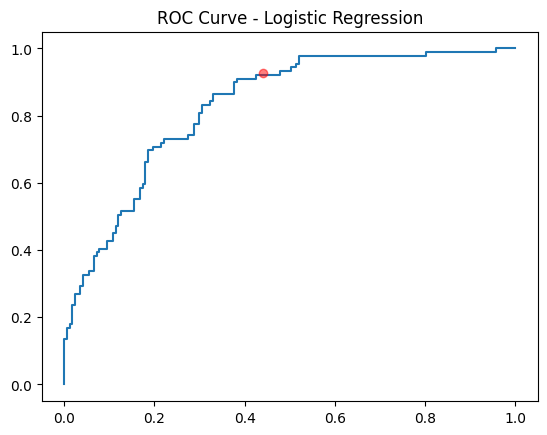

In [ ]:
diabetes = pickle.load(open("pimaDiabetes.p", 'rb'))
X = diabetes['data']
Y = diabetes['target'] # Ler o ficheiro pickle e separar os dados das respetivas classes 

xt, x2, yt, y2 = train_test_split(X, Y, test_size=1/3, random_state=42, stratify=Y) 
''' Separação dos conjuntos de treino e teste, usando 1/3 para teste.
    o Parâmetro Stratify = y faz com que a proporção dos dados e das classes seja dividida de forma idêntica nos dois conjuntos 
    (evita, por exemplo, que o conjunto de treino fique apenas com classes positivas)'''

scaler = StandardScaler() # Normalização dos dados com o Standard scaler, que coloca cada dimensao com méedia nula e variância unitária
xt = scaler.fit_transform(xt) # neste caso, os dados de treino são primeiro processados (fit) e só depois escalados
x2 = scaler.transform(x2)

classifiers = { # Os Hiper-parâmetros dos classficadores foram escolhidos de forma a maximizar os valores dados
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=1, max_features="sqrt", random_state=42),
    'SVC': SVC(random_state=42, C=0.1, kernel="linear", gamma=0.1, probability=True),
    'Logistic Regression': LogisticRegression(C=1, penalty='l2', solver='saga', max_iter=100, random_state=17)
}


results = {}

for name, clf in classifiers.items():  # Percorrer os classificadores
    # Treinar o classificador com os dados de treino
    clf.fit(xt, yt)

    # Obter a probabilidade das classes 1 para os dados de teste
    p = clf.predict_proba(x2)[:, 1]  # Probabilidade de cada linha (dados de uma mulher) ser da classe 1, dado os dados de teste

    # Encontrar o melhor limiar, matriz de confusão e outros parâmetros
    y_pred_opt, cm, best_threshold, best_balanced_accuracy, decision_point = find_optimal_threshold(y2, p)
    
    # Exibição de resultados
    print(f"{name} - Exatidão média: {best_balanced_accuracy:.4f}")
    print(f"{name} - Melhor Limiar: {best_threshold}")
    print(f"Matriz de Confusão para {name}:\n")
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # Exibição da curva ROC. Nesta curva pode-se ver o ponto operacional de cada classificador
    fp2, tp2, _ = roc_curve(y2, p)
    plt.plot(fp2, tp2)
    plt.plot(decision_point[0], decision_point[1], 'ro', alpha=0.5)
    plt.title(f"ROC Curve - {name}")
    plt.show()



Após carregar o ficheiro, os dados são separados pela sua dependência. Ou seja, **X representa os atributos dos pacientes** e **Y representa a presença ou ausência de diabetes**.
<br>
Este código treina e avalia três classificadores (Random Forest, Support Vector Classifier e Regressão Logística) para **prever diabetes com um conjunto de dados de pacientes**.<br>
Os astributos são eslacalados e as suas médias passam a ser 0 e o desvio padrão 1. A padronização é essencial em classificadores como SVC, pois a escala dos dados influencia os parâmetros do modelo. Ela ajuda a evitar que atributos com maiores valores dominem a decisão, alterando assim os resultados previstos. Em classificadores como o RandomForest, apesar de boa prática, a normalização não é necessária. <br>

<br>

Para o treino e avaliação dos classificadores, para cada classificador:<br>
- Treinou-se o classificador - _.fit()_ <br>
- Criou-se um limiar de decisão, sobre o qual o classificador prevê uma classe<br>
- Comparou-se essas previsões com o conjunto de teste original, calcula-se a matriz de confusão, <br>
  que mostra o número de previsões corretas e incorretas para cada classe, e um breve relatório de classificação.<br>

A **matriz de confusão** organiza as previsões em categorias:<br>
- **Verdadeiros Positivos (TP)**: casos positivos corretamente previstos.<br>
- **Verdadeiros Negativos (TN)**: casos negativos corretamente previstos.<br>
- **Falsos Positivos (FP)**: casos negativos incorretamente previstos como positivos.<br>
- **Falsos Negativos (FN)**: casos positivos incorretamente previstos como negativos.<br>
    
Para avaliar o desempenho de um classificador, usou-se um critério de _Balanced accuracy_, recorrendo à Especificidade (taxa de verdadeiro negativo) e à Sensibilidade (taxa de verdadeiro positivo, recall). Ao contrário da Accuracy 'normal', esta faz a média dos resultados, obtendo um valo mais fidedigno. 

Deve saber justificar as escolhas feitas no trabalho, tanto a n´ıvel da escolha das metodologias de treino/testes
usadas, como na selec¸ao dos classificadores implementados. Adicionalmente, deve tambem fazer uma analise rigorosa dos resultados obtidos. 

#### 4. Pré-processamento de dados

O pré-processamento de dados consiste na verificação se a normalização dos dados é ou não benéfica para o desempenho dos classificadores.


Para tal, os dados foram transformados de maneira a cada ter uma dimensão média nula e variância unitária



####  5. Comparação de desempenho de classificadores

Dado o contexto médico e, comparou-se entre os três classificadores a exatidão média e o valor de falsos negativos, dando mais prioridade e ênfase ao valor de falsos negativos. Desta forma, verifica-se que é com o Random Forest que se obtém uma melhor exatidão em relação aos outros dois classificadores. No entanto, a regressão logística permitir que haja menos um valor de falsos negativos comparado com o Random Forest, é uma característica mais importante para a seleção do classificador com o melhor desempenho nesta situação especificada. É possível então concluir que esse classificador é a regressão logística.

<a id="refs"></a>

#### 8. Referências

* <a href="https://docs.opencv.org/4.x/d7/dbd/group__imgproc.html" target="_blank">OpenCV: Image Processing</a>
* <a href="https://scikit-learn.org/1.5/api/index.html" target="_blank">API Reference - scikit-learn 1.5.2 documentation</a>
* <a href="https://www.databricks.com/br/glossary/machine-learning-models" target="_blank">O que são modelos de machine learning?</a>
* <a href="https://2425moodle.isel.pt/course/view.php?id=8502" target="_blank">Acetatos de Aprendizagem Automática, Moodle ISEL</a>